# PyTorch and Quantized Model Comparison on CIFAR-10 for Edge/Federated Learning

This notebook explores the training, validation, and comparison of deep learning models (MLP, CNN, MobileNetV3, EfficientNet-lite0) on the CIFAR-10 dataset. The goal is to analyze portability, reproducibility, and efficiency of these models on GPU and CPU, with a special focus on edge computing and federated learning scenarios.

**Key aspects:**
 - Reproducible training and evaluation of models on GPU and CPU.
 - Comparison of accuracy, inference times, and model size.
 - Reflection on portability and efficiency in distributed and federated AI.

In [1]:
# Automatic module reloading for interactive development
%load_ext autoreload
%autoreload 2

import os
import pickle

# Import libraries and utilities
import torch
import torch.nn.init as init

from models.cnn import CNN
from models.efficientnet_lite0 import EfficientNetLite0
from models.mlp import MLP
from models.mobilenetv3 import MobileNetV3
from utils.data_utils import get_cifar10_dataloaders
from utils.device_utils import get_available_devices, get_eval_devices, print_available_devices, select_main_device, \
    get_device_fullname
from utils.export_utils import save_model, load_model
from utils.metrics_utils import compute_confusion_matrix, plot_confusion_matrix, compute_classification_metrics
from utils.train_utils import train_model, evaluate_model
from utils.viz_utils import plot_loss_accuracy_curves, show_comparative_table, plot_bar_comparison


def initialize_weights_randomly(model: torch.nn.Module) -> None:
    """
    Initialize the weights of Conv2d, Linear, and BatchNorm layers in a model using Kaiming uniform initialization for weights and zeros/ones for biases.
    Args:
        model (torch.nn.Module): The model whose weights will be initialized.
    """
    for m in model.modules():
        if isinstance(m, torch.nn.Conv2d) or isinstance(m, torch.nn.Linear):
            init.kaiming_uniform_(m.weight, nonlinearity='relu')
            if m.bias is not None:
                init.zeros_(m.bias)
        elif isinstance(m, torch.nn.BatchNorm2d) or isinstance(m, torch.nn.BatchNorm1d):
            init.ones_(m.weight)
            init.zeros_(m.bias)

## CIFAR-10 Dataset Loading and Preprocessing

We use the project utilities to download and prepare the training and test DataLoaders, with standard data augmentation for small images.


In [2]:
# Load CIFAR-10
batch_size = 128
train_loader, test_loader = get_cifar10_dataloaders(batch_size=batch_size, data_augmentation=True)
num_classes = 10
input_shape = (3, 32, 32)


Files already downloaded and verified
Files already downloaded and verified


## Model Training and Loading

We train (or load if they already exist) the MLP, CNN, MobileNetV3, and EfficientNet-lite0 models. The models and their training histories are saved in `/models_saved` for reproducibility and comparison.


In [3]:
# Device configuration
import sys

sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))
from pathlib import Path

model_dir = Path(os.getcwd()).parent / 'models_saved'
model_dir.mkdir(exist_ok=True)

pytorch_dir = model_dir / 'pytorch'
pytorch_dir.mkdir(exist_ok=True)

model_configs = {
    'MLP': {
        'class': MLP,
        'args': {'input_size': 32 * 32 * 3, 'num_classes': num_classes},
        'file': 'mlp_cifar10.pt',
        'hist': 'mlp_cifar10_hist.pkl'
    },
    'CNN': {
        'class': CNN,
        'args': {'input_channels': 3, 'num_classes': num_classes, 'input_size': 32},
        'file': 'cnn_cifar10.pt',
        'hist': 'cnn_cifar10_hist.pkl'
    },
    'MobileNetV3': {
        'class': MobileNetV3,
        'args': {'num_classes': num_classes},
        'file': 'mobilenetv3_cifar10.pt',
        'hist': 'mobilenetv3_cifar10_hist.pkl'
    },
    'EfficientNetLite0': {
        'class': EfficientNetLite0,
        'args': {'num_classes': num_classes},
        'file': 'efficientnetlite0_cifar10.pt',
        'hist': 'efficientnetlite0_cifar10_hist.pkl'
    }
}

# Show available devices and select the main one for training
print_available_devices()
available_devices = get_available_devices()
device, device_name, device_type, device_id = select_main_device(available_devices)
print(f"Training will be done on {device_name} [{device_type}]")

histories = {}
models = {}
for name, cfg in model_configs.items():
    model = cfg['class'](**cfg['args'])
    initialize_weights_randomly(model)
    model_file = pytorch_dir / cfg['file']
    hist_path = model_dir / cfg['hist']
    # Try to load model and its history
    try:
        load_model(model, model_file, map_location=device.type)
        with open(hist_path, 'rb') as f:
            history = pickle.load(f)
        print(f"Model {name} loaded from disk.")
    except Exception:
        print(f"Training model {name}...")
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
        history = train_model(model, optimizer, train_loader, device, num_epochs=20)
        save_model(model, model_file, optimizer=None)
        with open(hist_path, 'wb') as f:
            pickle.dump(history, f)
    histories[name] = history
    models[name] = model


INFO:utils.device_utils:Available devices for backend 'pytorch':
INFO:utils.device_utils:- Intel(R) Core(TM) Ultra 9 185H [CPU]
INFO:utils.device_utils:- NVIDIA GeForce RTX 4080 Laptop GPU [GPU (id 0)]
INFO:utils.export_utils:Model loaded from C:\Users\padul\OneDrive\Universidad\Doctorado\Desarrollo\federated-lab-multihw\models_saved\mlp_cifar10.pt
INFO:utils.export_utils:Model loaded from C:\Users\padul\OneDrive\Universidad\Doctorado\Desarrollo\federated-lab-multihw\models_saved\cnn_cifar10.pt
INFO:utils.export_utils:Model loaded from C:\Users\padul\OneDrive\Universidad\Doctorado\Desarrollo\federated-lab-multihw\models_saved\mobilenetv3_cifar10.pt


Training will be done on NVIDIA GeForce RTX 4080 Laptop GPU [GPU]
Model MLP loaded from disk.
Model CNN loaded from disk.
Model MobileNetV3 loaded from disk.


INFO:utils.export_utils:Model loaded from C:\Users\padul\OneDrive\Universidad\Doctorado\Desarrollo\federated-lab-multihw\models_saved\efficientnetlite0_cifar10.pt


Model EfficientNetLite0 loaded from disk.


## Model Evaluation on GPU and CPU

All models are evaluated on GPU and CPU, recording accuracy, inference times, and model size. This allows for comparing portability and reproducibility across devices.


In [4]:


# Show available devices (full name and type)
print_available_devices()
available_devices = get_available_devices()

# Device selection for evaluation (professional and consistent)
eval_devices = get_eval_devices(available_devices)

results = []
for dev in eval_devices:
    device_fullname = get_device_fullname(dev, eval_devices)
    dev_type = dev.type if hasattr(dev, 'type') else str(dev)
    print(f"Evaluating models on {device_fullname} [{dev_type}]")
    for name, model in {**models}.items():
        eval_dev = dev
        metrics = evaluate_model(model, test_loader, eval_dev, verbose=False)
        model_path = model_configs.get(name.replace('_quant', ''), {}).get('file', f'{name}.pt')
        model_file = model_dir / model_path if (model_dir / model_path).exists() else None
        size = os.path.getsize(model_file) if model_file else None
        result = {
            'Modelo': name,
            'Device': dev_type,
            'Device_name': str(dev),
            'Device_fullname': device_fullname,
            'Accuracy': metrics['accuracy'],
            'Loss': metrics['loss'],
            'Tiempo_inferencia_total': metrics['total_time'],
            'Tiempo_inferencia_promedio': metrics['avg_inference_time'],
            'Tamaño_bytes': size
        }
        results.append(result)
        print(f"  -> {name}: Accuracy={result['Accuracy']:.4f}, Loss={result['Loss']:.4f}, "
              f"Total time={result['Tiempo_inferencia_total']:.2f}s, "
              f"Average time={result['Tiempo_inferencia_promedio'] * 1000:.2f}ms, "
              f"Size={result['Tamaño_bytes']} bytes")


INFO:utils.device_utils:Available devices for backend 'pytorch':
INFO:utils.device_utils:- Intel(R) Core(TM) Ultra 9 185H [CPU]
INFO:utils.device_utils:- NVIDIA GeForce RTX 4080 Laptop GPU [GPU (id 0)]


Evaluating models on Intel(R) Core(TM) Ultra 9 185H [cpu]
  -> MLP: Accuracy=0.4695, Loss=1.4916, Total time=7.92s, Average time=0.79ms, Size=3286256 bytes
  -> CNN: Accuracy=0.7735, Loss=0.6702, Total time=9.84s, Average time=0.98ms, Size=2188344 bytes
  -> MobileNetV3: Accuracy=0.7659, Loss=0.6759, Total time=16.96s, Average time=1.70ms, Size=6251626 bytes
  -> EfficientNetLite0: Accuracy=0.8307, Loss=0.4978, Total time=102.81s, Average time=10.28ms, Size=16390458 bytes
Evaluating models on NVIDIA GeForce RTX 4080 Laptop GPU [cuda]
  -> MLP: Accuracy=0.4695, Loss=1.4916, Total time=7.24s, Average time=0.72ms, Size=3286256 bytes
  -> CNN: Accuracy=0.7736, Loss=0.6702, Total time=7.28s, Average time=0.73ms, Size=2188344 bytes
  -> MobileNetV3: Accuracy=0.7660, Loss=0.6759, Total time=7.38s, Average time=0.74ms, Size=6251626 bytes
  -> EfficientNetLite0: Accuracy=0.8307, Loss=0.4977, Total time=7.92s, Average time=0.79ms, Size=16390458 bytes


## Results Visualization and Comparative Analysis

We plot the loss and accuracy curves, and display tables and bar charts to compare accuracy, times, and sizes across models and variants.


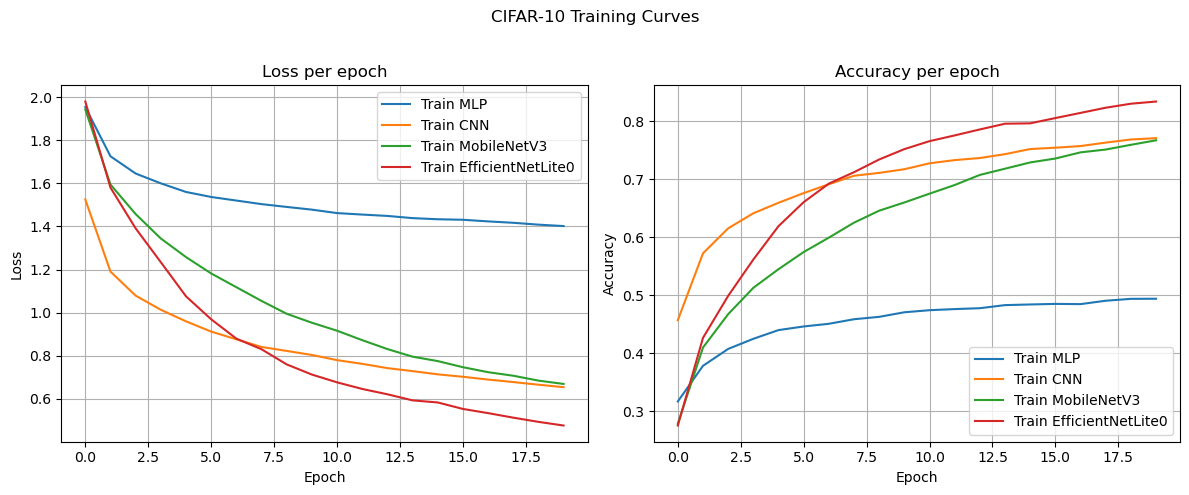

|                                                      |   Accuracy |     Loss |   Tiempo_inferencia_total |   Tamaño_bytes |
|------------------------------------------------------|------------|----------|---------------------------|----------------|
| MLP-Intel(R) Core(TM) Ultra 9 185H                   |     0.4695 | 1.4916   |                   7.91829 |    3.28626e+06 |
| CNN-Intel(R) Core(TM) Ultra 9 185H                   |     0.7735 | 0.670154 |                   9.84118 |    2.18834e+06 |
| MobileNetV3-Intel(R) Core(TM) Ultra 9 185H           |     0.7659 | 0.675892 |                  16.9563  |    6.25163e+06 |
| EfficientNetLite0-Intel(R) Core(TM) Ultra 9 185H     |     0.8307 | 0.49776  |                 102.807   |    1.63905e+07 |
| MLP-NVIDIA GeForce RTX 4080 Laptop GPU               |     0.4695 | 1.4916   |                   7.24403 |    3.28626e+06 |
| CNN-NVIDIA GeForce RTX 4080 Laptop GPU               |     0.7736 | 0.670154 |                   7.28235 |    2.1883

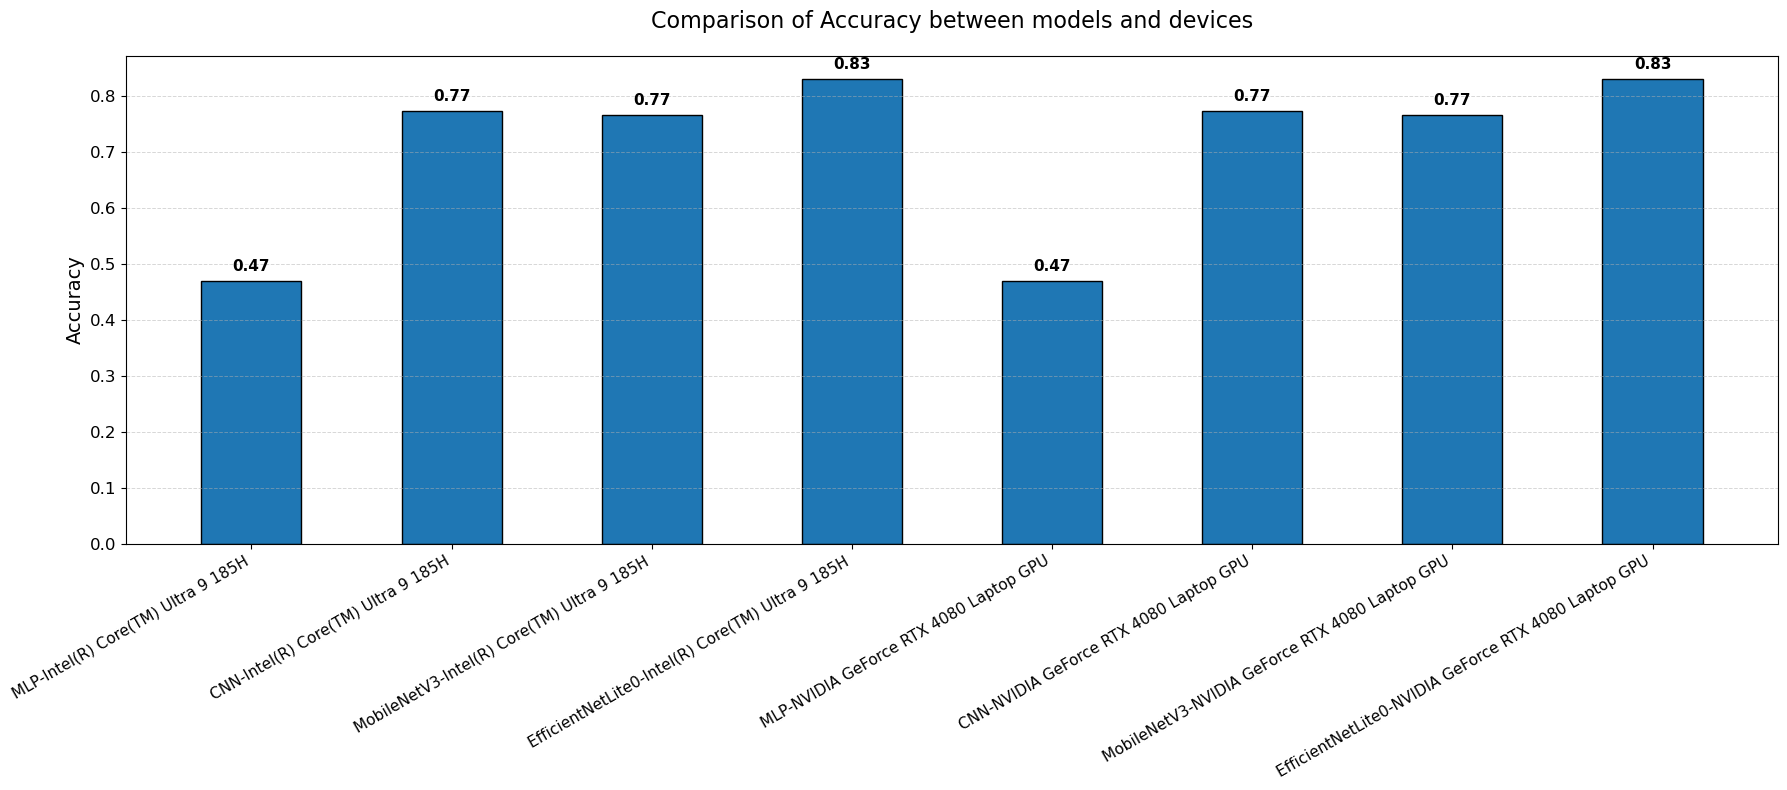

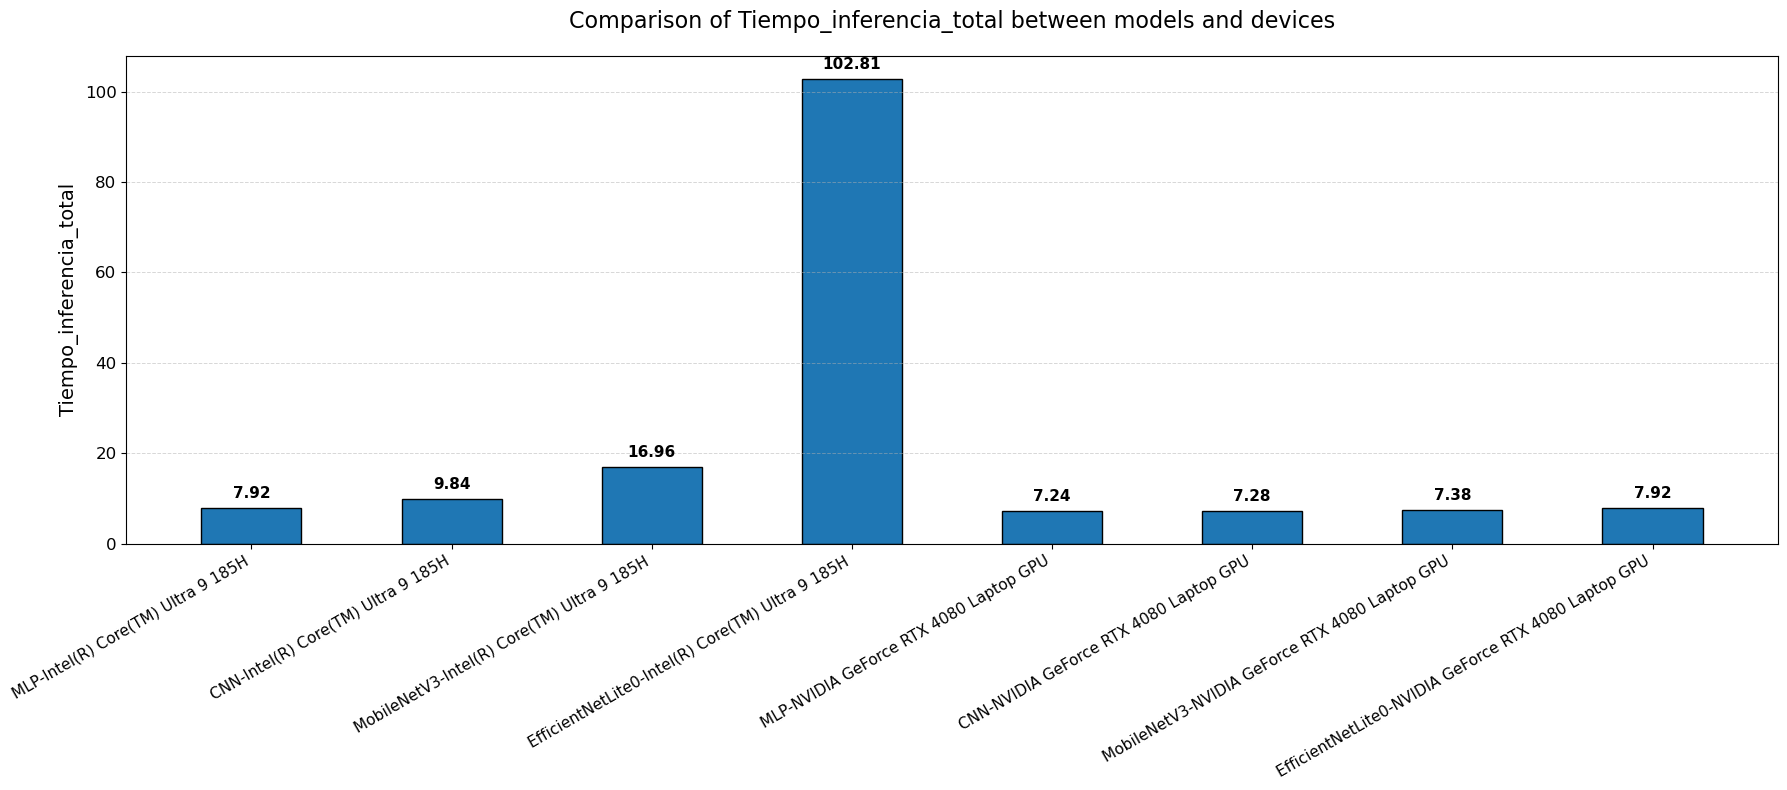

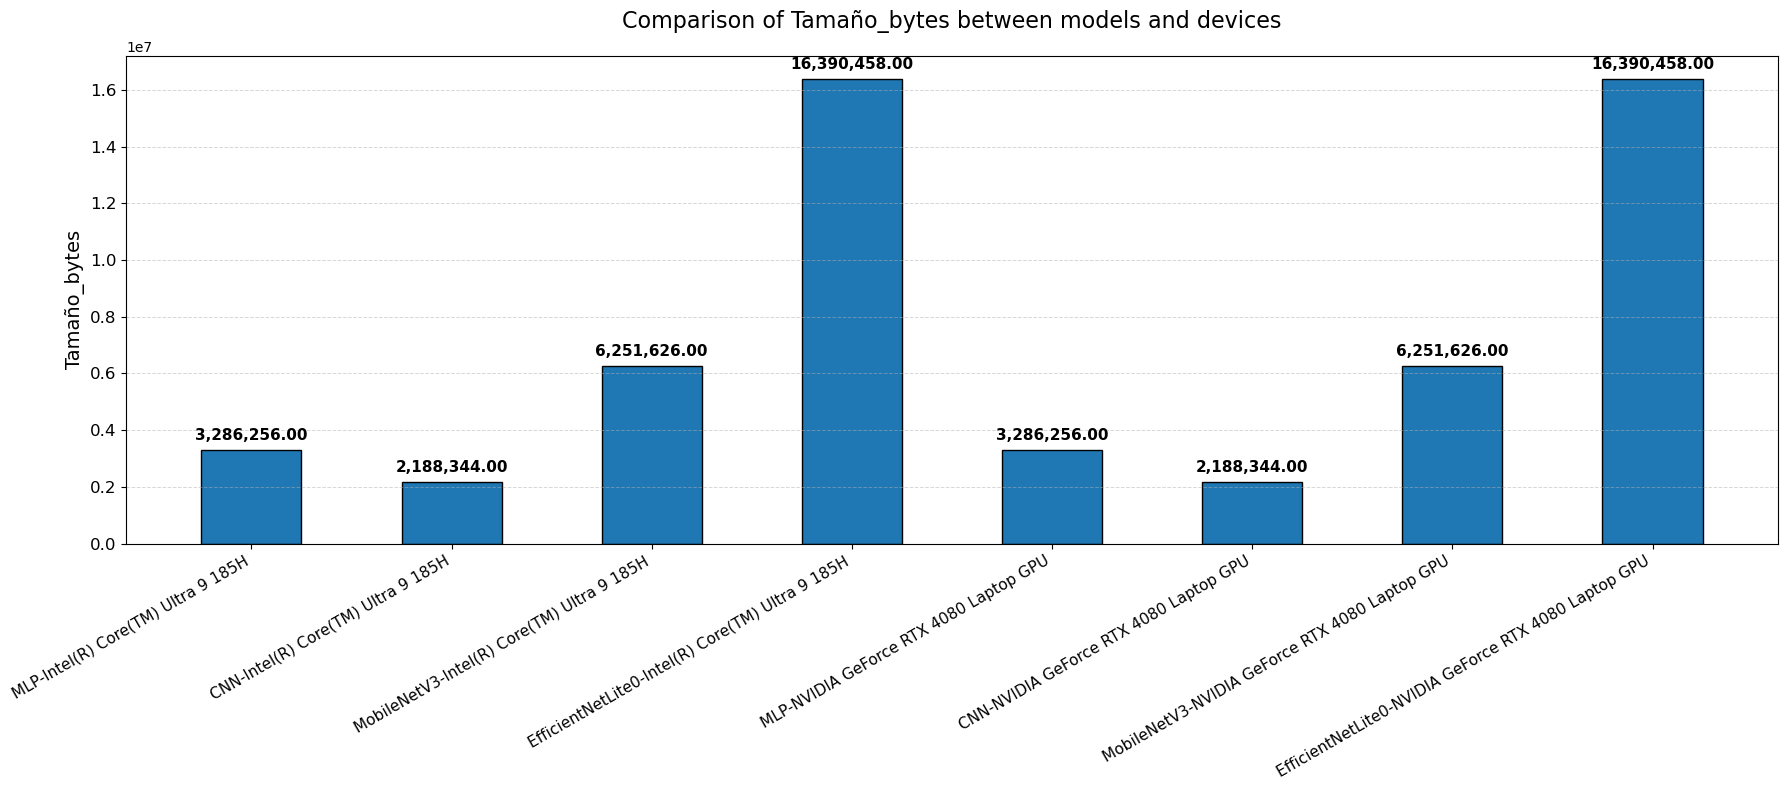

In [5]:
# Training curves
plot_loss_accuracy_curves([histories[k] for k in histories], labels=list(histories.keys()),
                          title="CIFAR-10 Training Curves")

# Comparative table
import pandas as pd

df_results = pd.DataFrame(results)
show_comparative_table(results, model_names=[r['Modelo'] + "-" + r['Device_fullname'] for r in results],
                       columns=['Accuracy', 'Loss', 'Tiempo_inferencia_total', 'Tamaño_bytes'])

# Bar charts
for metric in ['Accuracy', 'Tiempo_inferencia_total', 'Tamaño_bytes']:
    plot_bar_comparison(
        values=df_results[metric],
        labels=df_results['Modelo'] + "-" + df_results['Device_fullname'],
        ylabel=metric,
        title=f"Comparison of {metric} between models and devices"
    )


## Advanced Metrics and Confusion Matrix

In this section, we calculate and visualize advanced metrics (F1, precision, recall) and the confusion matrix
for the best normal model, using the CIFAR-10 test set.

Confusion Matrix - Normal Model


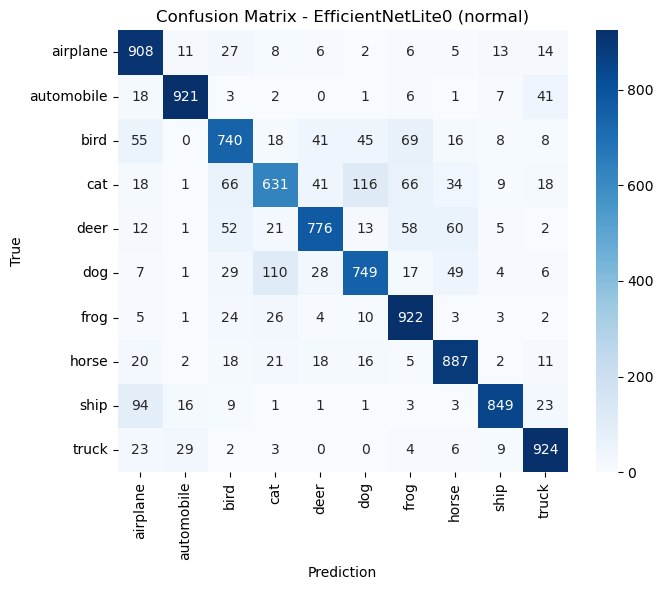

Global Metrics - Normal Model


,Accuracy,F1 (macro),Precision (macro),Recall (macro)
0,0.8307,0.829003,0.831295,0.8307


Class-wise Metrics - Normal Model


,F1,Precision,Recall
airplane,0.840741,0.782759,0.908
automobile,0.928896,0.936928,0.921
bird,0.751269,0.762887,0.740
cat,0.685497,0.750297,0.631
deer,0.810444,0.848087,0.776
dog,0.767025,0.785939,0.749
frog,0.855288,0.797578,0.922
horse,0.859496,0.833647,0.887
ship,0.889471,0.933993,0.849
truck,0.901903,0.880839,0.924


In [6]:
# Define CIFAR-10 class names
cifar10_classes = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

# Choose models to analyze (you can change to others if you wish)
best_normal = models['EfficientNetLite0'] if 'EfficientNetLite0' in models else list(models.values())[0]


# Get predictions and true labels for both models
def get_preds_and_labels(model, loader, device):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            outputs = model(x)
            preds = outputs.argmax(dim=1).cpu().numpy()
            y_pred.extend(preds)
            y_true.extend(y.numpy())
    return y_true, y_pred


# Normal
normal_y_true, normal_y_pred = get_preds_and_labels(best_normal, test_loader, device)

# Calculate and display confusion matrix
cm_normal = compute_confusion_matrix(normal_y_true, normal_y_pred, labels=cifar10_classes)

print('Confusion Matrix - Normal Model')
plot_confusion_matrix(cm_normal, class_names=cifar10_classes, title='Confusion Matrix - EfficientNetLite0 (normal)')

# Calculate advanced metrics
metrics_normal = compute_classification_metrics(normal_y_true, normal_y_pred, labels=cifar10_classes, as_dataframe=True)

print('Global Metrics - Normal Model')
display(metrics_normal['global'])
print('Class-wise Metrics - Normal Model')
display(metrics_normal['per_class'])


## Reflection: Portability, Efficiency, and Federated Learning

The analysis carried out in this notebook highlights the importance of evaluating deep learning models not only in terms of accuracy but also considering their portability, efficiency, and suitability for edge computing and federated learning scenarios.

- **Portability and reproducibility:** The ability to run and reproduce model results on different devices (CPU and GPU) is essential for real-world applications. The results show that, although there are slight numerical variations between devices, reproducibility is high and models maintain consistent performance. This portability is key for deployment in heterogeneous environments, where hardware resources may vary significantly.

- **Computational efficiency:** The comparison of inference times and model sizes evidences that, in this case, the CNN architecture offers a better balance between efficiency and accuracy than MobileNetV3, both on CPU and GPU. Although MobileNetV3 is designed to be efficient on mobile devices, in this specific environment, the CNN proves to be faster, more accurate, and more compact. This underscores the importance of empirically evaluating each architecture in the target context and hardware, as real-world performance may differ from theoretical expectations. This analysis is fundamental for applications on edge devices, where memory, power, and latency constraints are critical.

- **Implications for federated learning:** In the context of federated learning, the efficiency and portability of models become even more relevant. Compact and efficient models facilitate communication between nodes and allow for easier integration into devices with limited capabilities. Furthermore, reproducibility across devices ensures that results are comparable and reliable in a federated environment.

In conclusion, the rigorous selection and evaluation of models considering these factors is essential to advance towards artificial intelligence solutions that are truly applicable in distributed and federated scenarios. This approach maximizes the impact and scalability of machine learning systems in the real world.
